In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, utils
from pathlib import Path
from skimage import transform
import os
import torch.nn.functional as F

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
df_beauty=pd.read_csv('./data/data_raw_20190302/fashion_data_info_train_competition.csv')
df_beauty_validate=pd.read_csv('./data/data_raw_20190302/fashion_data_info_val_competition.csv')
display(len(df_beauty), df_beauty.head())
display(len(df_beauty_validate), df_beauty_validate.head())
for col in df_beauty:
    print((df_beauty[col].unique()))
    print(df_beauty[col].nunique())

275142

,itemid,title,image_path,Pattern,Collar Type,Fashion Trend,Clothing Material,Sleeves
0,2282553,retro floral dress,fashion_image/78d17fdb159bba51a4250dc3d583245e,2.0,NaN,3.0,NaN,NaN
1,13822218,dress floral sifon,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,2.0,NaN,NaN,4.0,NaN
2,33555935,korean white chiffon collar dress,fashion_image/6dbe2e7cba5ddbb750d2144d8f248f11,NaN,13.0,10.0,4.0,NaN
3,65755120,women s trendy apricot o neck solid chiffon bl...,fashion_image/dc9b21429604148fc0342d12694f3294,NaN,3.0,NaN,4.0,NaN
4,65857438,big sale baju gamis pesta india aysilla pancar...,fashion_image/6c25c578dd8edce742a805f891f1a51f,NaN,NaN,6.0,17.0,NaN


69498

,itemid,title,image_path
0,381034175,fashion wanita cardigan drape terbuka lengan p...,new_fashion_image/9ba6bf09ae89c2b9069faf569e7a...
1,396355150,bayar di tempat fashion wanita fg sweater hood...,new_fashion_image/f465cd2e55352e3ed9ab49b16257...
2,592583745,bayar di tempat cardigan sweater model lengan ...,new_fashion_image/18d709b8be0d8385689bbf5e0ab2...
3,721929368,blazer lengan panjang slim warna polos dengan ...,new_fashion_image/5c861844f6e497f0a56b8e37138c...
4,800794259,sweater rajut longgar lengan panjang warna polos,new_fashion_image/13fbe2dcbaa567939acf708d6d8e...


[   2282553   13822218   33555935 ... 1827137407 1828540009 1829477358]
275142
['retro floral dress' 'dress floral sifon'
 'korean white chiffon collar dress' ...
 'rl women s summer chiffon shirt trumpet sleeves loose tie v neck solid color'
 'women casual 3 4 sleeve lace patchwork t shirt tops'
 'wanita s1017 kaos o neck dkny lengan pendek spandek soft fit to l']
241693
['fashion_image/78d17fdb159bba51a4250dc3d583245e'
 'fashion_image/2f77dac9965bbfdb03cbd3724b3552c5'
 'fashion_image/6dbe2e7cba5ddbb750d2144d8f248f11' ...
 'fashion_image/b39777140d57e04aadd0b4b07a86db8b.jpg'
 'fashion_image/3c9f9b654b70b2c80e9f59acdc15a473.jpg'
 'fashion_image/c61ba632459162c5bdc70ea1e6ba3ca1.jpg']
275142
[ 2. nan  5.  1. 14.  9. 15. 18.  6. 19.  3. 12.  4.  8. 17. 13. 16.  7.
 10. 11.  0.]
20
[nan 13.  3.  8.  7. 11.  1.  4. 10.  5.  6.  0.  2. 14.  9. 15. 12.]
16
[ 3. nan 10.  6.  7.  8.  4.  1.  9.  2.  5.  0.]
11
[nan  4. 17.  3.  7.  2.  9.  5. 15. 18.  1. 14.  6. 16. 11. 12. 13.  0.
  8. 10.]
19

In [4]:
tfidfvectorizer=TfidfVectorizer(analyzer = "word", strip_accents=None, tokenizer = None, preprocessor = None, \
                             stop_words = None, max_features = 5000, ngram_range=(1,3))
tfidf=tfidfvectorizer.fit_transform(df_beauty['title'] )

In [5]:
tfidf

<275142x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5426521 stored elements in Compressed Sparse Row format>

# Make data loader
## Make function to show single image

data/data_raw_20190302/fashion_image
fashion_image/78d17fdb159bba51a4250dc3d583245e
data/data_raw_20190302/fashion_image/78d17fdb159bba51a4250dc3d583245e.jpg
(640, 640, 3)


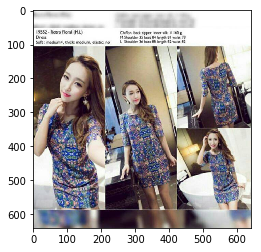

In [20]:
WORKDIR=Path('./data/data_raw_20190302/')
print(WORKDIR/'fashion_image')
def show_img(image_index):
    print(df_beauty.iloc[image_index]['image_path'])
    filename=df_beauty.iloc[image_index]['image_path']
    if filename[-4:]=='.jpg':
        imagepath=WORKDIR/(filename)
    else:
        imagepath=WORKDIR/(filename+'.jpg')
    
    print(imagepath)
    img=cv2.imread(str(imagepath))[:,:,::-1]
    print(np.shape(img))
    plt.imshow(img)
show_img(0)

## Build base dataset subclass from Dataset class

In [7]:
class ndscDataset(torch.utils.data.Dataset):
    def __init__(self, df, tfidf, rootdir, transform=None):
        self.df=df
        self.rootdir=rootdir
        self.tfidf=tfidf
        if transform:
            self.transform = transform
        else: self.transform=transform
    def __getitem__(self,index):
#         out = self.tensor[index]
#         out = TF.to_pil_image(out)
#         out = self.resize(out)
#         out = TF.to_tensor(out)
        filename=self.df.iloc[index]['image_path']
        if filename[-4:]=='.jpg':
            imagepath=WORKDIR/(filename)
        else:
            imagepath=WORKDIR/(filename+'.jpg')
#         imagepath=WORKDIR/(self.df.iloc[index]['image_path']+'.jpg')
        img=cv2.imread(str(imagepath))[:,:,::-1]
        label=self.df.iloc[index]['Sleeves']
        title_vector=self.tfidf[index, :].todense()
        sample={'image':img, 'label':label, 'title_vector':title_vector}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def __len__(self):
        return len(self.df)

### Test out subclass

0 (345, 345, 3) 0.0 1.8516713566653251
1 (800, 800, 3) 3.0 1.7992683850295375
2 (1024, 1024, 3) 0.0 2.1521513926129847
3 (1024, 1024, 3) 2.0 2.6487529683747404


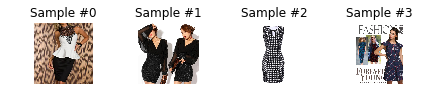

In [8]:
ndsc_dataset=ndscDataset(df_beauty[['image_path', 'Sleeves']].dropna(axis=0), tfidf, WORKDIR)
len(ndsc_dataset)
fig = plt.figure()

for i in range(len(ndsc_dataset)):
    sample = ndsc_dataset[i]

    print(i, sample['image'].shape, sample['label'], np.sum(sample['title_vector']))

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break


## Make transformations to images
Rescale and convert to tensor. Might add jittering in the future?

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple)
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label, title_vector = sample['image'], sample['label'], sample['title_vector']
        new_h, new_w = self.output_size
        img = transform.resize(image, (new_h, new_w))

        return {'image':img, 'label':label, 'title_vector':title_vector}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, title_vector = sample['image'], sample['label'], sample['title_vector']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(np.array(label)), 
                'title_vector': torch.from_numpy(title_vector)}

## Display images with transformation

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0 torch.Size([3, 400, 400]) tensor(0., dtype=torch.float64) torch.Size([1, 5000])
1 torch.Size([3, 400, 400]) tensor(3., dtype=torch.float64) torch.Size([1, 5000])
2 torch.Size([3, 400, 400]) tensor(0., dtype=torch.float64) torch.Size([1, 5000])
3 torch.Size([3, 400, 400]) tensor(2., dtype=torch.float64) torch.Size([1, 5000])


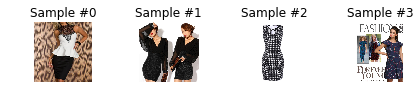

In [10]:
ndsc_dataset=ndscDataset(df_beauty[['image_path', 'Sleeves']].dropna(axis=0), tfidf, WORKDIR, transform=transforms.Compose([
    Rescale((400, 400)), ToTensor()]))

plt.figure(1)
for i in range(len(ndsc_dataset)):
    sample = ndsc_dataset[i]

    print(i, sample['image'].shape, sample['label'], np.shape(sample['title_vector']))

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(np.transpose(sample['image'], (1, 2, 0)))

    if i == 3:
        plt.show()
        break

## Use DataLoader to do batching, shuffling, on dataset.

0 torch.Size([4, 3, 400, 400]) tensor([3., 3., 3., 2.], dtype=torch.float64) torch.Size([4, 1, 5000])
1 torch.Size([4, 3, 400, 400]) tensor([2., 2., 3., 3.], dtype=torch.float64) torch.Size([4, 1, 5000])
2 torch.Size([4, 3, 400, 400]) tensor([3., 3., 3., 0.], dtype=torch.float64) torch.Size([4, 1, 5000])
3 torch.Size([4, 3, 400, 400]) tensor([2., 3., 3., 3.], dtype=torch.float64) torch.Size([4, 1, 5000])


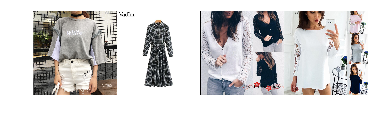

In [11]:
dataloader = torch.utils.data.DataLoader(ndsc_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, label = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'], sample_batched['title_vector'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [12]:
df_beauty.nunique()

itemid               275142
title                241693
image_path           275142
Pattern                  20
Collar Type              16
Fashion Trend            11
Clothing Material        19
Sleeves                   4
dtype: int64

In [13]:
# def initiate_pretrained(nfeatures):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print('initiate model, device is, ', device)
#     #net = mdl.Net()
#     net = models.resnet50(pretrained=True)
#     for param in net.parameters():
#             param.requires_grad = False
#     num_features = net.fc.in_features
#     net.fc = nn.Linear(num_features, nfeatures)
#     print('convert')
#     net = net.to(device)
#     #net.to(device)
#     print('model initiated')
#     return net
# net=initiate_pretrained(4)
# # define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [70]:
class myModule(nn.Module):
    def __init__(self, nfeatures):
        super(myModule, self).__init__()
        self.resnet=models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad=False
        self.nfeatures=nfeatures
        num_features=self.resnet.fc.in_features
        print(list(self.resnet.children()))
        modules=list(self.resnet.children())[:-1]
        self.resnet=nn.Sequential(*modules)

#         self.resnet.fc=nn.Linear(num_features, 2048)
        self.fcs=nn.Sequential(
            nn.Dropout(), nn.Linear(num_features+5000, 2048), nn.ReLU(inplace=False), 
            nn.Dropout(), nn.Linear(2048, self.nfeatures))
#         self.drop1=nn.Dropout(p=0.5)
#         self.fc1=nn.Linear(2048+5000, 2048)
#         self.drop2=nn.Dropout(p=0.5)
#         self.fc2=nn.Linear(2048, self.nfeatures)

    def forward(self, image, data):
        x1=self.resnet(image)
        x=torch.cat((x1, torch.squeeze(data)), dim=1)
        x=self.fcs(x)
#         x=self.drop1(x, inplace=True)
#         x=F.relu(self.fc1(x))
#         x=self.drop2(x)
#         x=self.fc2(x)
        return x

In [17]:
def initiate_pretrained_comb(nfeatures):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('initiate model, device is, ', device)
    net=myModule(nfeatures)
    print('convert')
    net = net.to(device)
    print('model initiated')
    return net
net=initiate_pretrained_comb(4)
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

initiate model, device is,  cuda:0
convert
model initiated


In [72]:
net=myModule(4)
list(net.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [18]:
def tts(df, feature, train_ratio=0.8):
    ndsc_dataset_train=ndscDataset(df.iloc[:int(len(df)*train_ratio)][['image_path', feature]].dropna(axis=0), tfidf, WORKDIR, transform=transforms.Compose([
        Rescale((224, 224)), ToTensor()]))
    ndsc_dataset_test=ndscDataset(df.iloc[int(len(df)*train_ratio):][['image_path', feature]].dropna(axis=0), tfidf, WORKDIR, transform=transforms.Compose([
        Rescale((224, 224)), ToTensor()]))
    return torch.utils.data.DataLoader(ndsc_dataset_train, batch_size=1000,
                        shuffle=True, num_workers=4), torch.utils.data.DataLoader(ndsc_dataset_test, batch_size=1000,
                        shuffle=True, num_workers=4)

ndsc_trainloader, ndsc_testloader=tts(df_beauty, 'Sleeves')

In [22]:
def train_model(net, trainloader, criterion, optimizer,f):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(1): #100
        running_loss=0.0
        for i, data in enumerate(trainloader):
            inputs, labels, title_vector = data['image'], data['label'], data['title_vector']
#             print('labels', labels)
            inputs, labels, title_vector = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long), title_vector.to(device, dtype=torch.float)
            optimizer.zero_grad()
            outputs = net(inputs, title_vector)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 5==4:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 5),file=f)
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i+1, running_loss/5))
                running_loss = 0.0
    print('Finished Training')
    return net

def scoring(net, testloader, f):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels, title_vector = data['image'], data['label'], data['title_vector']
            inputs, labels, title_vector = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long), title_vector.to(device, torch.float)
            outputs = net(inputs, title_vector)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print('predicted',predicted,'label',labels)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total),file=f)

with open('transfer_learning_output.txt', 'a') as f:
    net = train_model(net, ndsc_trainloader, criterion, optimizer, f)
    print('training complete', f)
    scoring(net, ndsc_testloader, f)
    
torch.save(net.state_dict(), './model_weights.pt')
torch.save(net,'model.pt')

sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 torch.Size([1000, 3, 224, 224]) torch.Size([1000, 1, 5000])
sizes2 torch.Size([1000, 2048]) torch.Size([1000, 5000])
sizes1 t

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type myModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
predictings=['Pattern', 'Collar Type', 'Fashion Trend', 'Clothing Material']
for thing in predictings:
    ndsc_trainloader, ndsc_testloader=tts(df_beauty, thing)
    net=initiate_pretrained(df_beauty[thing].nunique())
    with open('transfer_learning_output_'+thing+'.txt', 'a') as f:
        net = train_model(net, ndsc_trainloader, criterion, optimizer, f)
        print('training complete', f)
        scoring(net, ndsc_testloader, f)
    torch.save(net.state_dict(), './model_weights_'+thing+'.pt')
    torch.save(net,'model_'+thing+'.pt')

# Make submission

In [42]:
def loader_maker(df_train, df_test, train_tfidf, test_tfidf, feature):
    ndsc_dataset_train=ndscDataset(df_train[['image_path', feature]].dropna(axis=0), train_tfidf, WORKDIR, transform=transforms.Compose([
        Rescale((224, 224)), ToTensor()]))
    ndsc_dataset_test=ndscDataset(df_test[['image_path', feature]].dropna(axis=0), test_tfidf, WORKDIR, transform=transforms.Compose([
        Rescale((224, 224)), ToTensor()]))
    return torch.utils.data.DataLoader(ndsc_dataset_train, batch_size=1000,
                        shuffle=True, num_workers=4), torch.utils.data.DataLoader(ndsc_dataset_test, batch_size=1000,
                        shuffle=True, num_workers=4)

def predictor(net, testloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_preds=[]
    with torch.no_grad():
        for data in testloader:
            inputs, labels, title_vector = data['image'], data['label'], data['title_vector']
            inputs, labels, title_vector = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long), title_vector.to(device, torch.float)
            outputs = net(inputs, title_vector)
            _, predictions = torch.topk(outputs.data, 4)
            all_preds.append(predictions.cpu().numpy())
    return all_preds


In [ ]:
def create_submission_list(trainpath, validpath):
    df_train=pd.read_csv(trainpath)
    items=[thing for thing in df_train.columns if thing not in ['itemid', 'image_path', 'title']]
    print(items)
    vectorizer = CountVectorizer(analyzer = "word", strip_accents=None, tokenizer = None, preprocessor = None, \
                                 stop_words = None, max_features = 5000, ngram_range=(1,3))
    train_data_features = vectorizer.fit_transform(df_train['title'])
    tfidfier = TfidfTransformer()
    train_tfidf = tfidfier.fit_transform(train_data_features)
    df_valid=pd.read_csv(validpath)
    valid_data_features=vectorizer.transform(df_valid['title'])
    valid_tfidf=tfidfier.transform(valid_data_features)
    ids=df_valid['itemid']
    predictions=[]
    for item in items:
        ndsc_trainloader, ndsc_testloader=loader_maker(df_train, df_test, train_tfidf, test_tfidf, 'Sleeves')
        net=initiate_pretrained_comb(df_train[item].nunique())
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        with open('transfer_learning_output.txt', 'a') as f:
            net = train_model(net, ndsc_trainloader, criterion, optimizer, f)
            print('training complete', f)
        
        y_predicts_list=predictor(net, ndsc_testloader, f).cpu().to_array()
        y_predicts=np.concatenate(y_predicts_ist)
        ids_feature=[str(x)+'_'+item for x in ids]
        tags=[]
        for item in y_predicts:
            tags.append(" ".join(map(str, map(int, item))))
        predictions.append(pd.DataFrame({'id':ids_feature, 'tagging':tags}))
    return predictions

In [ ]:
predictions_beauty=create_submission_list('./data/data_raw_20190302/beauty_data_info_train_competition.csv', \
                                        './data/data_raw_20190302/beauty_data_info_val_competition.csv')

In [ ]:
with open('predictions_beauty.pickle', 'wb') as f:
    pickle.dump(predictions_beauty, f)

In [49]:
!jupyter nbconvert --to script image_classification_ndsc.ipynb

[NbConvertApp] Converting notebook image_classification_ndsc.ipynb to script
[NbConvertApp] Writing 14794 bytes to image_classification_ndsc.py


In [14]:
df_beauty['Pattern'].notnull().values
# tfidf.tocsr()[df_beauty['Pattern'].notnull(), :].shape()
tfidf[df_beauty['Pattern'].notnull().values]

<164078x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3229915 stored elements in Compressed Sparse Row format>

In [5]:
from pathlib import Path
import os

In [4]:
ROOTDIR=Path('./data/data_raw_20190302')
ROOTDIR

PosixPath('data/data_raw_20190302')

In [7]:
os.listdir('./data/data_raw_20190302')

['new_fashion_image',
 '.resize_image.py.swp',
 'fashion_data_info_val_competition.csv',
 'mobile_profile_train.json',
 'data_info_val_sample_submission.csv',
 'fashion_image',
 'beauty_data_info_val_competition.csv',
 'mobile_data_info_train_competition.csv',
 'beauty_image_sml',
 'fashion_data_info_train_competition.csv',
 'beauty_profile_train.json',
 'beauty_data_info_train_competition.csv',
 'mobile_image',
 'beauty_image',
 'fashion_profile_train.json',
 'mobile_data_info_val_competition.csv']